本次作业以垃圾邮件分类任务为基础，要求提取文本特征并使用朴素贝叶斯算法进行垃圾邮件识别（调用已有工具包或自行实现）。

### 任务介绍
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

本次实验

基本要求：
1. 提取正文部分的文本特征；
2. 划分训练集和测试集（可以借助工具包。一般笔记本就足够运行所有数据，认为实现困难或算力不够的同学可以采样一部分数据进行实验。）；
3. 使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9（本次实验可以使用已有的一些工具包完成如sklearn）；
4. 对比特征数目（词表大小）对模型效果的影响；
5. 提交代码和实验报告。

扩展要求：
1. 邮件头信息有时也可以协助判断垃圾邮件，欢迎学有余力的同学们尝试；
2. 尝试自行实现朴素贝叶斯算法细节；
3. 尝试对比不同的概率计算方法。

### 导入工具包

In [1]:
'''
提示：
若调用已有工具包，sklearn中提供了一些可能会用到的类。
'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 提取文本特征向量的类
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 三种朴素贝叶斯算法，差别在于估计p(x|y)的方式
import pandas as pd
import os

### 读取数据

In [2]:
def split_email(text):
    lines = text.split('\n')
    n = len(lines)
    for i in range(n):
        if len(lines[i].strip()) == 0:
            break
    return ' '.join(lines[:i]), ' '.join([line.strip() for line in lines[i:] if len(line.strip()) > 0])

In [3]:
line_list = []
with open('trec06c-utf8/label/index', 'r') as f:
    for line in f.readlines():
        line_data = {}
        label, email_file = line.split(' ')
        line_data['label'] = 1 if label == 'spam' else 0
        email_text = open(email_file.strip().replace('../data', 'trec06c-utf8/data_cut')).read()
        line_data['header'], line_data['body'] = split_email(email_text)
        line_list.append(line_data)

In [4]:
data = pd.DataFrame(line_list)

In [5]:
data.head()

,label,header,body
0,1,Received: from hp-5e1fe6310264 ([218.79.188.13...,[ 课 程 背 景 ] 每 一位 管理 和 技术人员 都 清楚 地 懂得 ， 单...
1,0,Received: from jdl.ac.cn ([159.226.42.8]) \tby...,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...
2,1,Received: from 163.con ([61.141.165.252]) \tby...,尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！ 我 是 深圳 金海 实业 有限...
3,1,Received: from 12.com ([222.50.6.150]) \tby sp...,贵 公司 负责人 ( 经理 / 财务 ） 您好 ： 深圳市 华龙 公司 受 多家 公司 委托...
4,1,Received: from dghhkjk.com ([59.36.183.208]) \...,这是 一封 HTML 格式 信件 ！ - - - - - - - - - - - - - -...


### 划分数据集

In [6]:
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
RANDOM_SEED = 2020
# 划分训练集和测试集
def split(X, Y, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=RANDOM_SEED)
    return x_train, x_test, y_train, y_test

In [7]:
X = data['body']
Y = data['label']
x_train, x_test, y_train, y_test = split(X, Y)
print(len(x_train), len(x_test))

51696 12924


In [8]:
x_train.iloc[:10]

12641    当然 要 先 说 说 啊 一个 寝室 三个 人 ， 周末 或者 有时 一 室友 会 回家 ，...
54076    电子邮件 地址 库 分为 企业 用户 地址 ， 个人 地址 以及 国际 邮件地址 。 其中 ...
15196    您好 ！ 很 高兴 认识 您 。 我司 有意 与 您们 合作 : 可 长久 给 您们 带来 ...
980      随着 市场经济 的 发展 ， 名优 商品 被 假冒 的 事件 也 屡 有 发生 ， 这 不仅...
5494     >   TO ; 负责人 : > >                            ...
53188    没有 环境 , 我 就 自己 创造 环境 , 难到 非 得到 什么 大学 .. 什么 研究所...
10638    ☆ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ...
62595    需要 用 小心翼翼 来 形容 的 联系 , 亲爱 的 楼主 你 认为 它 能 持续 多久 ?...
18572    深   圳   市   安   科   达   实   业   有   限   公   司 ...
20513    第 98 届 交易会 联营 参展 邀请 尊敬 的 客户 ： 中国 出口商品 交易会 ， 又称...
Name: body, dtype: object

### 文本特征提取

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = 0.01, max_df = 0.8)
cv_fit = cv.fit_transform(x_train)

In [11]:
cv.get_feature_names_out()

array(['00', '01', '010', ..., '高级', '魅力', '麻烦'], dtype=object)

In [12]:
cv.vocabulary_

{'当然': 872,
 '一个': 169,
 '三个': 203,
 '或者': 955,
 '有时': 1134,
 '回家': 631,
 '大部分': 702,
 '时间': 1093,
 '所以': 960,
 '那个': 1706,
 '经常': 1445,
 '男朋友': 1321,
 '一次': 189,
 '正在': 1198,
 '外面': 684,
 '直接': 1336,
 '还有': 1668,
 '大家': 698,
 '怎么': 898,
 '如果': 724,
 '难道': 1758,
 '还是': 1667,
 '怎么办': 899,
 '电子邮件': 1313,
 '地址': 653,
 '企业': 344,
 '用户': 1304,
 '个人': 260,
 '以及': 337,
 '国际': 647,
 '邮件地址': 1714,
 '其中': 426,
 '按照': 1002,
 '行业': 1535,
 '地区': 652,
 '进行': 1683,
 '分类': 462,
 '价格': 341,
 '100': 16,
 '120': 20,
 '300': 57,
 '以上': 332,
 '光盘': 406,
 '群发': 1478,
 '软件': 1650,
 '搜索': 1025,
 '全国': 408,
 '所有': 962,
 '每个': 1203,
 '一张': 186,
 '购买': 1622,
 '全部': 414,
 '2000': 39,
 '如何': 722,
 '联系电话': 1500,
 '客户': 770,
 '汇款': 1217,
 '联系': 1497,
 '我们': 950,
 '然后': 1262,
 '一定': 182,
 '金额': 1734,
 '05': 8,
 '180': 33,
 '15': 26,
 '以便': 335,
 '区别': 503,
 '电话': 1318,
 '通知': 1697,
 '产品': 301,
 '详细': 1603,
 '姓名': 729,
 '邮编': 1718,
 '需要': 1764,
 '传真': 357,
 '银行': 1736,
 '查询': 1179,
 '每天': 1204,
 '00': 0,
 '收到': 1032,


In [14]:
cv_fit.toarray().shape

(51696, 1799)

In [15]:
train_x_fit = cv.transform(x_train).toarray()
test_x_fit = cv.transform(x_test).toarray()

### 模型构建

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB()
}

def model_predict(x_train, y_train, x_test, y_test):
    data = []
    for model_name ,clf in model.items():
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        data.append({
            'model': model_name, 
            'accuracy': accuracy_score(y_pred,y_test), 
            'precision': precision_score(y_pred, y_test), 
            'recall': recall_score(y_pred, y_test)
        })
    return pd.DataFrame(data)

In [79]:
model_predict(train_x_fit, y_train, test_x_fit, y_test)

,model,accuracy,precision,recall
0,MultinomialNB,0.957521,0.964444,0.971146
1,BernoulliNB,0.895466,0.862573,0.976692
2,ComplementNB,0.945373,0.944444,0.972189


可以看出，多项式朴素贝叶斯的准确率和精准率都是最高的，三个模型的召回率差别不大，都有97%。接下来，对比特征数目（词表大小）对模型效果的影响。

In [88]:
def compare_cvsize(max_feature):
    cv = CountVectorizer(max_features=max_feature)
    cv.fit(x_train)
    train_x_fit = cv.transform(x_train).toarray()
    test_x_fit = cv.transform(x_test).toarray()
    df = model_predict(train_x_fit, y_train, test_x_fit, y_test)
    df['max_feature'] = max_feature
    return df

In [89]:
max_features = [10, 50, 100, 200, 500, 1000, 1500]
cmp_df = pd.DataFrame()
for max_feature in max_features:
        cmp_df = pd.concat([cmp_df, compare_cvsize(max_feature)], ignore_index=True)

In [90]:
import seaborn as sns

<AxesSubplot:xlabel='max_feature', ylabel='accuracy'>

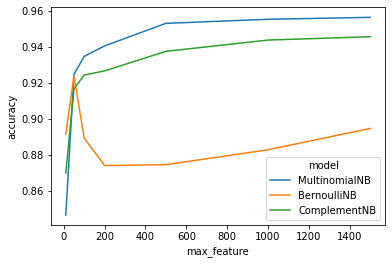

In [92]:
sns.lineplot(x='max_feature', y='accuracy', hue='model', data=cmp_df)

<AxesSubplot:xlabel='max_feature', ylabel='precision'>

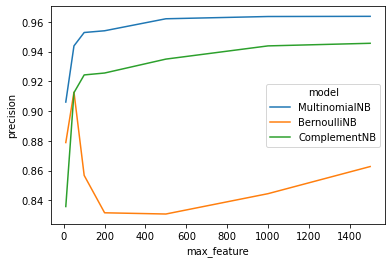

In [93]:
sns.lineplot(x='max_feature', y='precision', hue='model', data=cmp_df)

<AxesSubplot:xlabel='max_feature', ylabel='recall'>

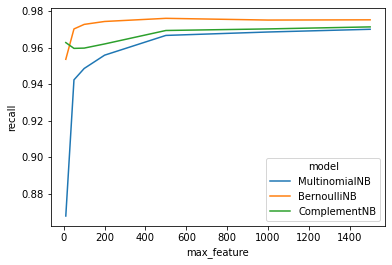

In [94]:
sns.lineplot(x='max_feature', y='recall', hue='model', data=cmp_df)

可以看出基本上特征数量增加，预测的准确率、精确度和召回率都会随之提升。总的来看MultinonmiaNB(多项式贝叶斯)的效果会比其他两个好，但是召回率比其他两个都低。

下面将从邮件头信息和TF-IDF两方面优化

In [101]:
data['header'][0]

'Received: from hp-5e1fe6310264 ([218.79.188.136]) \tby spam-gw.ccert.edu.cn (MIMEDefang) with ESMTP id j7CAoGvt023247 \tfor <lu@ccert.edu.cn>; Sun, 14 Aug 2005 09:59:04 +0800 (CST) Message-ID: <200508121850.j7CAoGvt023247@spam-gw.ccert.edu.cn> From: "yan"<(8月27-28,上海)培训课程> Reply-To: yan@vip.163.com"<b4a7r0h0@vip.163.com> To: lu@ccert.edu.cn Subject: =?gb2312?B?t8eyxs7xvq3A7bXEssbO8bncwO0to6jJs8XMxKPE4qOp?= Date: Tue, 30 Aug 2005 10:08:15 +0800 MIME-Version: 1.0 Content-type: multipart/related;     type="multipart/alternative";     boundary="----=_NextPart_000_004A_2531AAAC.6F950005" X-Priority: 3 X-MSMail-Priority: Normal X-Mailer: Microsoft Outlook Express 6.00.2800.1158 X-MimeOLE: Produced By Microsoft MimeOLE V6.00.2800.1441'

In [223]:
import re
import base64
import jieba
def parse_sender(header):
    try:
        sender = re.search('From: ([^\s]*)', header).group(1)
        try:
            gbd = re.search('=\?GB2312\?B\?(.*)\?=', sender, re.I).group(1)
            sender = base64.b64decode(gbd).decode('gb2312')
        except:
            pass
    except:
        sender = ''
    return ' '+sender
def parse_receiver(header):
    try:
        receiver = re.search('To: ([^\s]*)', header).group(1)
    except:
        receiver = ''
    return ' '+receiver
def parse_subject(header):
    try:
        subject = re.search('Subject: ([^\s]*)', header).group(1)
        try:
            gbd = re.search('=\?GB2312\?B\?(.*)\?=', subject, re.I).group(1)
            subject = base64.b64decode(gbd).decode('gb2312')
        except:
            pass
    except:
        subject = ''
    return ' ' + " ".join(jieba.cut(subject))

In [224]:
data['sender'] = data['header'].map(parse_sender)
data['receiver'] = data['header'].map(parse_receiver)
data['subject'] = data['header'].map(parse_subject)

In [225]:
data.head()

,label,header,body,sender,receiver,subject
0,1,Received: from hp-5e1fe6310264 ([218.79.188.13...,[ 课 程 背 景 ] 每 一位 管理 和 技术人员 都 清楚 地 懂得 ， 单...,"""yan""<(8月27-28,上海)培训课程>","yan@vip.163.com""<b4a7r0h0@vip.163.com>",非 财务经理 的 财务管理 - （ 沙盘 模拟 ）
1,0,Received: from jdl.ac.cn ([159.226.42.8]) \tby...,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...,"""pan""",shi@ccert.edu.cn,● 问 一部 魏宗万 的 电影 名称
2,1,Received: from 163.con ([61.141.165.252]) \tby...,尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！ 我 是 深圳 金海 实业 有限...,张海南,xing@ccert.edu.cn,公司 业务 . 代 开发票 ！
3,1,Received: from 12.com ([222.50.6.150]) \tby sp...,贵 公司 负责人 ( 经理 / 财务 ） 您好 ： 深圳市 华龙 公司 受 多家 公司 委托...,代开发票,ling@ccert.edu.cn,低点 代 开发票 !
4,1,Received: from dghhkjk.com ([59.36.183.208]) \...,这是 一封 HTML 格式 信件 ！ - - - - - - - - - - - - - -...,"""mei""",tang@ccert.edu.cn,一边 上网冲浪 ， 一边 赚钱 ， 何乐而不为 ？


In [226]:
data['body'] = data['body'] + data['sender'] + data['receiver'] + data['subject']

In [227]:
X = data['body']
Y = data['label']
x_train, x_test, y_train, y_test = split(X, Y)

In [229]:
tfidf = TfidfVectorizer(min_df = 0.01)
tfidf.fit(x_train)
train_x_fit = tfidf.transform(x_train).toarray()
test_x_fit = tfidf.transform(x_test).toarray()
model_predict(train_x_fit, y_train, test_x_fit, y_test)

,model,accuracy,precision,recall
0,MultinomialNB,0.973228,0.973333,0.986019
1,BernoulliNB,0.928582,0.910292,0.980350
2,ComplementNB,0.965568,0.959064,0.988547
